In [7]:
!git clone https://github.com/scottjaymsu/nlp-autograder.git
%cd nlp-autograder

Cloning into 'nlp-autograder'...
remote: Enumerating objects: 333, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 333 (delta 73), reused 8 (delta 7), pack-reused 224 (from 1)
Receiving objects: 100% (333/333), 114.15 MiB | 16.48 MiB/s, done.
Resolving deltas: 100% (184/184), done.
/content/nlp-autograder/nlp-autograder


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix

from tqdm import tqdm

from transformers import BertTokenizer, BertModel

import seaborn as sns

In [10]:
# load and process data
data = pd.read_csv('train.csv').dropna() # read in train dataset csv
X = data.iloc[:, 1] # create iterable of text data entries
y = data.iloc[:, 2].astype(int) # create iterable of labels and make them ints
max_score = y.max() # keep track of max label
min_score = y.min()

# print some info about data
print(X.head())
print(y.head())
print(f"\nMinimum score: {min_score}")
print(f"\nMaximum score: {max_score}")

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# set device for training / testing to run on (should be cuda)
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')


0    Many people have car where they live. The thin...
1    I am a scientist at NASA that is discussing th...
2    People always wish they had the same technolog...
3    We all heard about Venus, the planet without a...
4    Dear, State Senator\n\nThis is a letter to arg...
Name: full_text, dtype: object
0    3
1    3
2    4
3    4
4    3
Name: score, dtype: int64

Minimum score: 1

Maximum score: 6


In [11]:
# function to train and retrieve bert cls embeddings for text data
def get_bert_embeddings(texts, device='cuda'):
    # initialize bert tokenizer
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    # initialize pretrained bert model
    bert = BertModel.from_pretrained("bert-base-uncased").to(device)

    # set to evaluation mode
    bert.eval()

    embeddings = []

    # using tqdm for a progress bar
    for text in tqdm(texts, desc="Processing texts", unit="text"):
        with torch.no_grad():
            # tokenize text, pad it to the max length, truncate if needed (some will need), convert to tensor, and set max length
            inputs = tokenizer(text, padding=True, truncation=True, return_tensors='pt').to(device)

            # pass through pretrained model to get embeddings for text
            outputs = bert(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], token_type_ids=inputs['token_type_ids'])

            # get the cls token embeddings that capture longer term dependencies in text
            cls_token_embedding = outputs.last_hidden_state[:, 0, :]

            # remove extra dimension and add cls token vector to list
            embeddings.append(cls_token_embedding.squeeze(0))

    # combine all embeddings into a single tensor
    embeddings_tensor = torch.stack(embeddings)

    return embeddings_tensor

In [12]:
# generate embeddings for train and test
features_tensor = get_bert_embeddings(X_train)
features_tensor_test = get_bert_embeddings(X_test)

# convert labels to tensors, making all labels -1 their original values for convienence
labels_tensor = torch.tensor(y_train.values - 1, dtype=torch.long)
labels_tensor_test = torch.tensor(y_test.values - 1, dtype=torch.long)

Processing texts: 100%|██████████| 1702/1702 [00:45<00:00, 37.44text/s]


In [15]:
# Example of data
print(f"\nFeature vector of first datapoint: {features_tensor[0]}")


Feature vector of first datapoint: tensor([-7.7415e-01, -6.7077e-02, -4.3229e-01,  8.8857e-02, -6.9774e-02,
        -4.2646e-01,  1.0718e-01,  5.0898e-01,  5.8255e-01, -1.0124e+00,
         3.3230e-01, -5.3216e-01, -1.7524e-01,  6.9424e-01, -4.3522e-02,
         1.6904e-01,  3.1919e-01,  5.5084e-01,  1.4371e-01,  3.2336e-01,
        -1.9212e-02,  2.9638e-02,  9.9957e-01,  6.9174e-01,  2.2098e-01,
        -6.0440e-01, -4.3541e-01, -2.3010e-01, -8.2108e-01,  2.2530e-01,
        -3.5412e-01,  6.8809e-01, -9.1765e-01, -1.6078e+00,  4.2631e-01,
        -6.1380e-01, -3.9803e-01, -2.1468e-01, -5.1566e-02,  2.6148e-01,
        -7.9568e-02,  2.4649e-01, -1.2178e-01, -2.9205e-01, -6.4111e-01,
         2.3563e-02, -5.0531e+00,  6.9221e-01, -5.2487e-01, -5.5398e-01,
         1.0565e-01, -6.4318e-01, -1.4577e-01,  7.3163e-01,  7.7932e-01,
         4.1964e-01, -6.4457e-01, -2.3130e-01, -1.3569e-01,  4.4865e-02,
         7.8442e-01, -3.0167e-01, -1.8143e-01, -7.8473e-01, -4.8900e-01,
         2.0864

In [16]:
# create fully connected NN model
class FCNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FCNN, self).__init__()

        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), # initial layer
            nn.Sigmoid(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim), # hidden layer
            nn.Sigmoid(),
            nn.Linear(hidden_dim, output_dim) # output layer
        )
        # sigmoid used as activiation function for all layers
        # dropout used during training to eliminate unnecessary weights since this NN is fully connected

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [18]:
# function to plot confusion matrix
def plot_confusion_matrix(y_actual, y_pred):
    cm = confusion_matrix(y_actual, y_pred) # compute confusion matrix using sklearn

    # plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(0, 6), yticklabels=range(0, 6))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# function to plot individual accuracy scores
def plot_individual_scores(y_actual, y_pred, beta=1):

  cm = confusion_matrix(y_actual, y_pred) # compute confusion matrix using sklearn

  classes = cm.shape[0]  # determine number of classes from cm dimensions
  individual_accuracy = []
  individual_precision = []
  individual_recall = []
  individual_fbeta = []

  for i in range(classes):
      # compute tp, fp, and fn from confusion matrix
      tp = cm[i, i] # tp is where row = columns
      fp = np.sum(cm[:, i]) - tp # data in column are fp except those tp
      fn = np.sum(cm[i, :]) - tp # data in row are fn except those tp
      tn = np.sum(cm) - (tp + fp + fn) # all datapoints not in row or column are tn

      # compute metrics
      accuracy = (tp + tn) / np.sum(cm)
      precision = tp / (tp + fp)
      recall = tp / (tp + fn)
      fbeta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

      # append metrics to list
      individual_accuracy.append(accuracy)
      individual_precision.append(precision)
      individual_recall.append(recall)
      individual_fbeta.append(fbeta)

  class_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']
  metrics = {
    "Accuracy": individual_accuracy,
    "Precision": individual_precision,
    "Recall": individual_recall,
    "Fbeta Score": individual_fbeta
  }

  results_df = pd.DataFrame(metrics, index=class_labels)
  print(results_df.to_string(index=True))



Train Set Accuracy: 0.6473266745005876


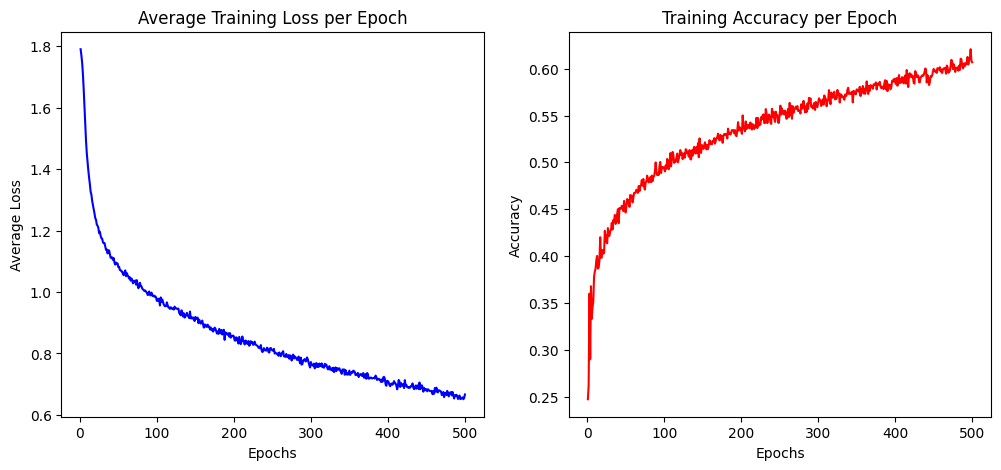

In [19]:
# function for training model
def train_model(model, dataloader, loss_fn, optimizer, epochs=100):
    model.train()  # set to training mode

    # store loss and accuracy for each epoch
    losses = []
    accuracies = []

    # train for chosen epochs
    for epoch in range(epochs):
        total_loss = 0.0  # keep track of total loss
        total = 0 # track total predictions
        correct = 0 # track correct predictions

        for inputs, labels in dataloader:   # loop through batches using DataLoader
            inputs, labels = inputs.to(device), labels.to(device) # move data to GPU
            optimizer.zero_grad() # zeros out gradient from last run
            outputs = model(inputs) # compute logits
            loss = loss_fn(outputs, labels) # determine loss
            total_loss += loss.item() # add loss to total loss
            loss.backward() # perform backpropagation compute gradients
            optimizer.step() # update weights

            correct += torch.eq(torch.argmax(outputs, dim=1), labels).sum().item()
            total += len(labels)

        accuracy = correct / total # accuracy of epoch
        total_loss /= len(dataloader) # average loss of epoch

        # store to graph learning curve
        losses.append(total_loss)
        accuracies.append(accuracy)

    model.eval() # switch to evaluation mode
    y_actual, y_pred = [], []
    with torch.no_grad(): 	# no_grad mode doesn't compute gradients
      for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) # gets index of highest logit (predicted class value)
        # add labels from batch to lists as arrays
        y_actual.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

    # plot accuracy and loss curves over epochs
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), losses, label="Loss", color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Average Loss')
    plt.title('Average Training Loss per Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), accuracies, label="Accuracy", color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy per Epoch')

    # compute and print overall accuracy
    train_accuracy = accuracy_score(y_actual, y_pred)
    print(f"\nTrain Set Accuracy: {train_accuracy}")

    # return actual/predicted labels for further visualization
    return y_actual, y_pred


# format feature vector tensor and label tensor into dataset
train_dataset_full = TensorDataset(features_tensor, labels_tensor)
# create dataloader with dataset, shuffling data and using batch size of 64
train_loader_full = DataLoader(train_dataset_full, batch_size=64, shuffle=True)

# create model instance
model = FCNN(input_dim=features_tensor.shape[1], hidden_dim=128, output_dim=max_score).to(device)

# compute class weights with balanced weighting (less frequent classes have higher weight)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y)
# convert weights into tensor
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# define loss_fn to be cross entropy loss: applies softmax to logits and computes cross entropy from softmax
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# optimizer for model: scales learning rates independently for weights
optimizer = optim.Adam(model.parameters(), lr=0.0001)

y_actual_train, y_pred_train = train_model(model, train_loader_full, loss_fn, optimizer, epochs=500) # perform training


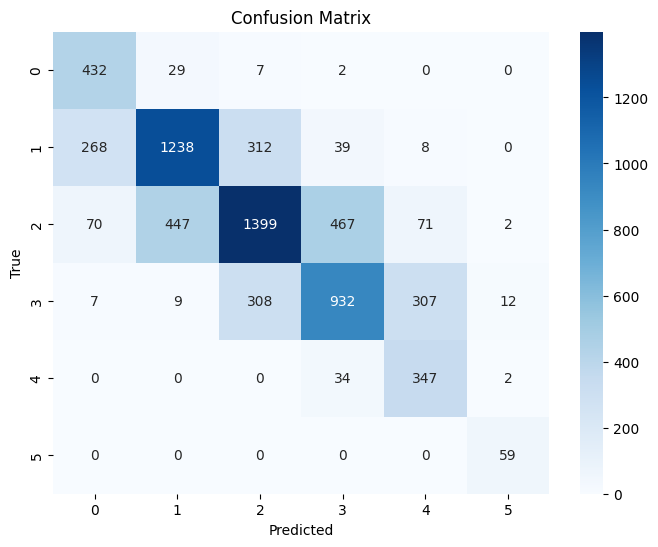

         Accuracy  Precision    Recall  Fbeta Score
Class 0  0.943743   0.555985  0.919149     0.692863
Class 1  0.836663   0.718514  0.663807     0.690078
Class 2  0.752644   0.690523  0.569625     0.624275
Class 3  0.825940   0.632293  0.591746     0.611348
Class 4  0.938014   0.473397  0.906005     0.621864
Class 5  0.997650   0.786667  1.000000     0.880597


In [20]:
# plot confusion matrix and accuracies for training
plot_confusion_matrix(y_actual_train, y_pred_train)
plot_individual_scores(y_actual_train, y_pred_train)

Fold 1/5

Train Set Accuracy: 0.6355123026074183
Fold 1 Accuracy: 0.5161527165932452
Fold 1 Loss: 1.5262879918922077
Fold 2/5

Train Set Accuracy: 0.6406536907822254
Fold 2 Accuracy: 0.5440528634361234
Fold 2 Loss: 1.4620051194321027
Fold 3/5

Train Set Accuracy: 0.641571795813441
Fold 3 Accuracy: 0.5256975036710719
Fold 3 Loss: 1.6570416201244702
Fold 4/5

Train Set Accuracy: 0.6359463925096384
Fold 4 Accuracy: 0.5216752387950037
Fold 4 Loss: 1.4963964576070958
Fold 5/5

Train Set Accuracy: 0.6387002019460253
Fold 5 Accuracy: 0.5554739162380602
Fold 5 Loss: 1.5299288061532108


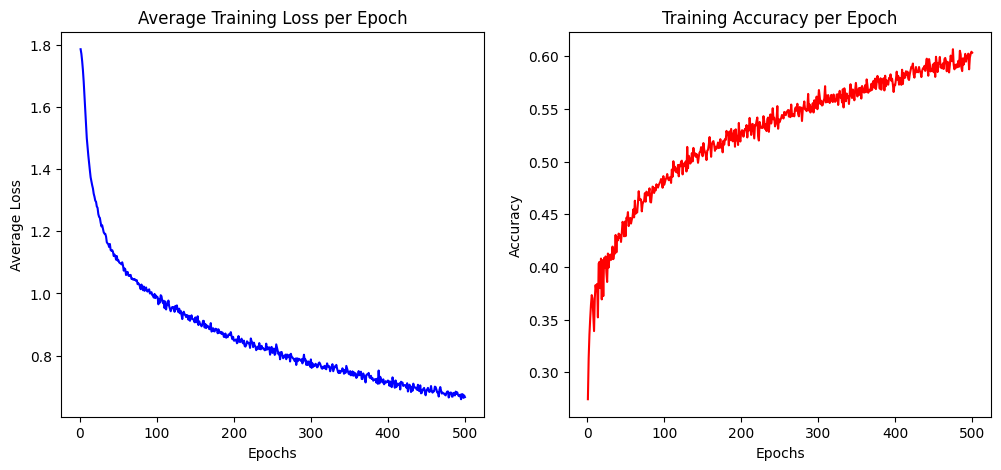

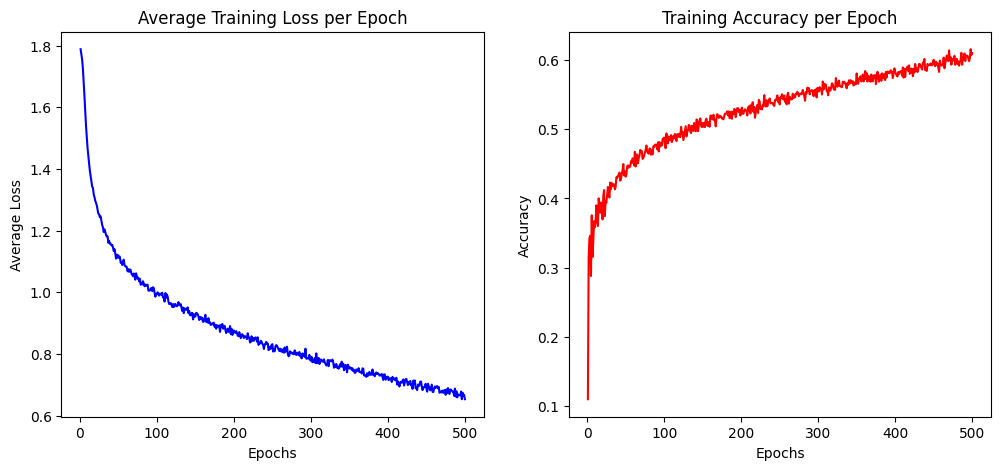

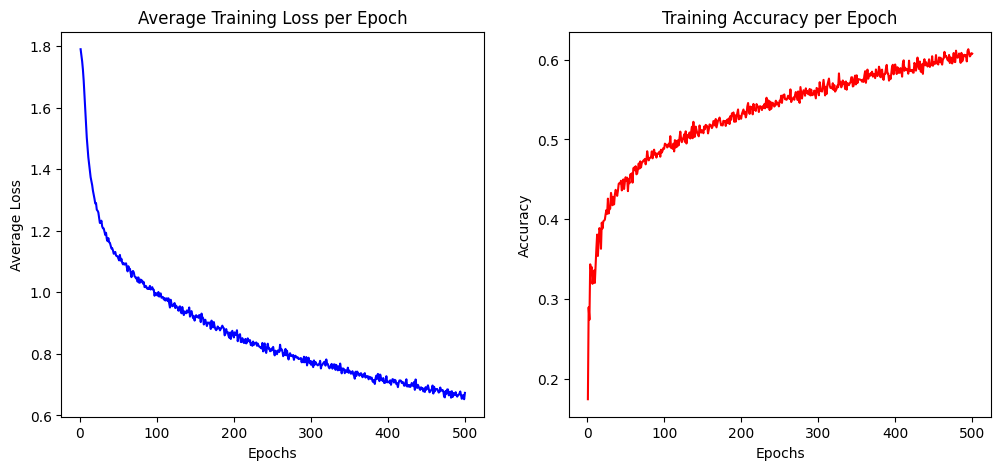

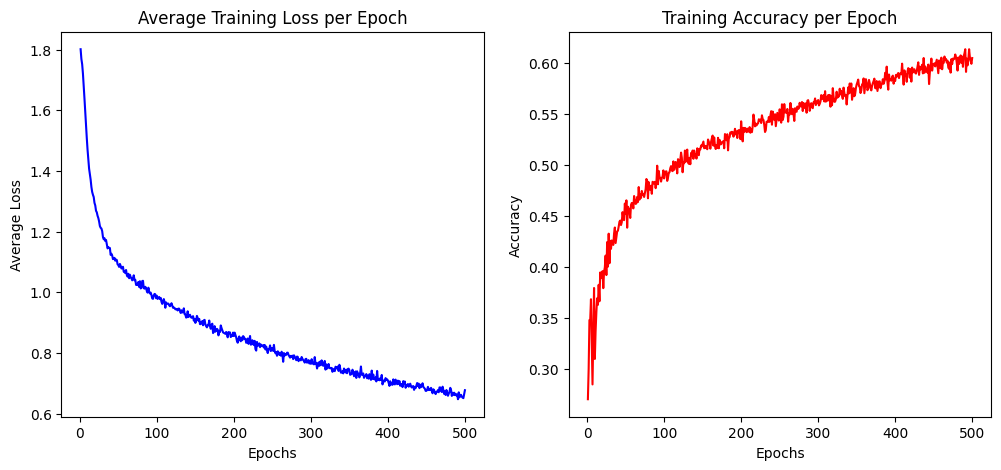

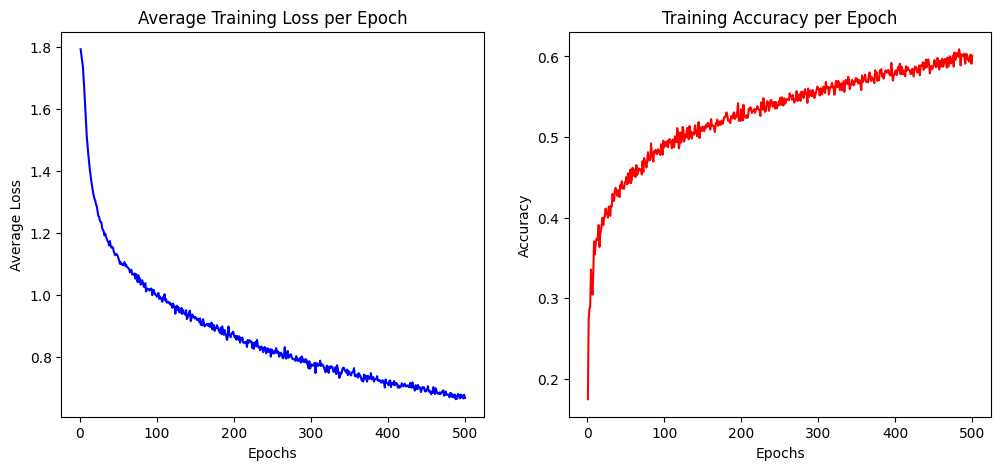

In [25]:
# cross validate model using 5 folds
k_folds = 5
kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42) # create splitter for data

fold_accuracies = []

# loop for the number of folds in cross validation, each time with a different validation set
for fold, (train_idx, val_idx) in enumerate(kf.split(features_tensor, labels_tensor)): # data split
    print(f"Fold {fold + 1}/{k_folds}")

    # create tensors for the features/labels of the training and validation splits based on lists of indices
    train_features, val_features = features_tensor[train_idx], features_tensor[val_idx]
    train_labels, val_labels = labels_tensor[train_idx], labels_tensor[val_idx]

    # create datasets and dataloaders for these tensors
    train_dataset = TensorDataset(train_features, train_labels)
    val_dataset = TensorDataset(val_features, val_labels)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    # create a new model for this fold of validation
    model = FCNN(input_dim=features_tensor.shape[1], hidden_dim=128, output_dim=max_score).to(device)

    # class weights established with same method as training/testing
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    # loss function and optimizer same as for training/testing
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    _, _ = train_model(model, train_loader, loss_fn, optimizer, epochs=500) # train model

    # eval on validation set
    model.eval()
    y_actual, y_pred = [], []
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += loss_fn(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            y_actual.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    val_loss = val_loss / len(val_loader)
    fold_accuracy = accuracy_score(y_actual, y_pred)
    fold_accuracies.append(fold_accuracy)
    print(f"Fold {fold + 1} Accuracy: {fold_accuracy}")
    print(f"Fold {fold + 1} Loss: {val_loss}")


In [26]:
'''
Notes on hyperparameter tuning:
  - Decreasing learning rate reduces overfitting but also reduces accuracy and performance
  - Increasing number of hidden units improves accuracy but decreases performance significantly
  - Batch size decreases improve accuracy but decrease performance significantly
  - Increased number of epochs improves performance up to about 600, all gains after that are overfitting
  - Changes in dropout rate yield only slight reduction of overfitting
'''

'\nNotes on hyperparameter tuning:\n  - Decreasing learning rate reduces overfitting but also reduces accuracy and performance\n  - Increasing number of hidden units improves accuracy but decreases performance significantly\n  - Batch size decreases improve accuracy but decrease performance significantly\n  - Increased number of epochs improves performance up to about 600, all gains after that are overfitting\n  - Changes in dropout rate yield only slight reduction of overfitting\n'

In [27]:
# average validation accuracy
average_accuracy = np.mean(fold_accuracies)
print(f"\nAverage accuracy across {k_folds} folds: {average_accuracy}")



Average accuracy across 5 folds: 0.5326104477467009



Train Set Accuracy: 0.6511457109283196

Test Set Accuracy: 0.5534665099882491

Test Set Loss: 0.06537238209008843


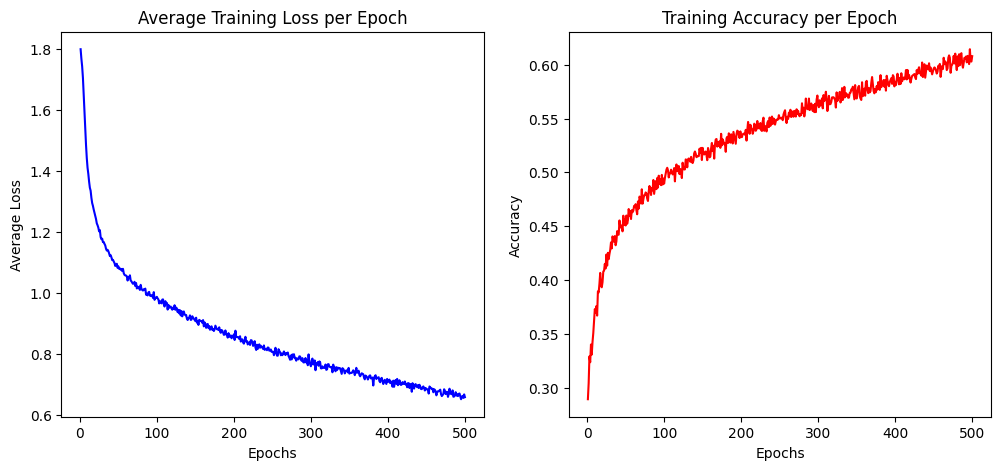

In [28]:
# retrain
train_dataset_full = TensorDataset(features_tensor, labels_tensor)
train_loader_full = DataLoader(train_dataset_full, batch_size=64, shuffle=True)

model = FCNN(input_dim=features_tensor.shape[1], hidden_dim=128, output_dim=len(np.unique(y))).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

_, _ = train_model(model, train_loader_full, loss_fn, optimizer, epochs=500)

test_dataset = TensorDataset(features_tensor_test, labels_tensor_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# eval on test set
model.eval()
test_loss = 0
y_actual_test, y_pred_test = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_loss += loss_fn(outputs, labels).item()
        _, predicted = torch.max(outputs, 1)
        y_actual_test.extend(labels.cpu().numpy())
        y_pred_test.extend(predicted.cpu().numpy())

test_loss = test_loss / len(test_loader)
test_accuracy = accuracy_score(y_actual_test, y_pred_test)
print(f"\nTest Set Accuracy: {test_accuracy}")
print(f"\nTest Set Loss: {test_loss / len(test_loader)}")

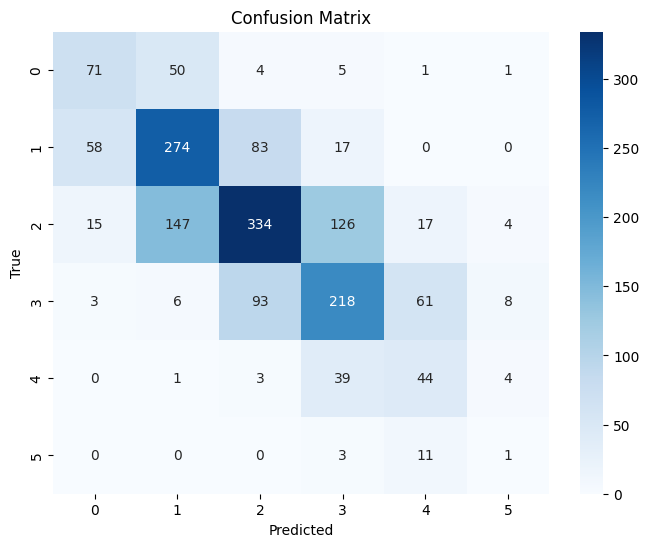

         Accuracy  Precision    Recall  Fbeta Score
Class 0  0.919506   0.482993  0.537879     0.508961
Class 1  0.787309   0.573222  0.634259     0.602198
Class 2  0.710928   0.646035  0.519440     0.575862
Class 3  0.787897   0.534314  0.560411     0.547051
Class 4  0.919506   0.328358  0.483516     0.391111
Class 5  0.981786   0.055556  0.066667     0.060606


In [29]:
# plot confusion matrix and accuracies for testing
plot_confusion_matrix(y_actual_test, y_pred_test)
plot_individual_scores(y_actual_test, y_pred_test)

In [30]:
kappa_score = cohen_kappa_score(y_actual_test, y_pred_test)
print(f"\nQuadratic Kappa Score: {kappa_score}")


Quadratic Kappa Score: 0.40316440247921725


In [31]:
# macro metrics: calculated for each class and averaged
precision_macro = precision_score(y_actual_test, y_pred_test, average='macro')
recall_macro = recall_score(y_actual_test, y_pred_test, average='macro')
fscore_macro = fbeta_score(y_actual_test, y_pred_test, beta=1, average='macro')

# micro metrics: sums of tp, fp, and fn to perform calculations
precision_micro = precision_score(y_actual_test, y_pred_test, average='micro')
recall_micro = recall_score(y_actual_test, y_pred_test, average='micro')
fscore_micro = fbeta_score(y_actual_test, y_pred_test, beta=1, average='micro')

# weighted average of metrics calculated independently for each class
precision_weighted = precision_score(y_actual_test, y_pred_test, average='weighted')
recall_weighted = recall_score(y_actual_test, y_pred_test, average='weighted')
fscore_weighted = fbeta_score(y_actual_test, y_pred_test, beta=1, average='weighted')

print("Precision (Macro):", precision_macro)
print("Recall (Macro):", recall_macro)
print("F1 Score (Macro):", fscore_macro)
print("Precision (Micro):", precision_micro)
print("Recall (Micro):", recall_micro)
print("F1 Score (Micro):", fscore_micro)
print("Precision (Weighted):", precision_weighted)
print("Recall (Weighted):", recall_weighted)
print("F1 Score (Weighted):", fscore_weighted)

Precision (Macro): 0.43674621014160747
Recall (Macro): 0.4670287721319964
F1 Score (Macro): 0.4476315098780182
Precision (Micro): 0.5534665099882491
Recall (Micro): 0.5534665099882491
F1 Score (Micro): 0.5534665099882491
Precision (Weighted): 0.5671852277409734
Recall (Weighted): 0.5534665099882491
F1 Score (Weighted): 0.5563541538811698
